In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pyargus import directionEstimation as de
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error
from utils import get_data_per_anchor, spatial_plot
from matplotlib import pyplot as plt
from matplotlib import colors

In [193]:
torch.manual_seed(42)
np.random.seed(42)

In [194]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [195]:
params = {
    "test_size":0.33,
    "random_state":42,
    "splits":3,
    
}

In [196]:
df = pd.read_pickle("raw_IQ.pkl")
df.sort_values(['point', 'anchor', 'room', 'channel'], inplace=True)

In [197]:
cols2 = ['pdda_input_imag1','pdda_input_imag2','pdda_input_imag3','pdda_input_imag4','pdda_input_imag5']
cols1 = ['pdda_input_real1','pdda_input_real2','pdda_input_real3','pdda_input_real4','pdda_input_real5']

def unpack(row):
    a,b,c,d,e = row
    return a,b,c,d,e
    
df[cols1] = df.apply(lambda row: unpack(row['pdda_input_real']), axis=1, result_type='expand')
df[cols2] = df.apply(lambda row: unpack(row['pdda_input_imag']), axis=1, result_type='expand')

In [198]:
min_max_scaler = StandardScaler()
df[cols2] = min_max_scaler.fit_transform(df[cols2])
df[cols1] = min_max_scaler.fit_transform(df[cols1])

In [199]:
cols3 = ['element1','element2','element3','element4','element5']
def complexify(reals,imags):
    complexs = []
    for i in range(len(reals)):
        complexs.append(reals[i] + 1j*imags[i])
    a,b,c,d,e = complexs
    return a,b,c,d,e

df[cols3] = df.apply(lambda row: complexify(row[cols1], row[cols2]), axis=1, result_type='expand')

In [200]:
# d = 0.5 # Inter element spacing [lambda]
M = 5  # number of antenna elements in the antenna system (ULA)
N = 6  # sample size used for the simulation  
M0 = 5
def construct_R(df):
    cols = ['element1','element2','element3','element4','element5']
    grouped = df.groupby(['room','anchor', 'point'],as_index=False)
    outputs = []
    inputs = []
    x_loc = []
    y_loc = []
    pts = []
    pdda = []
    counter = 0
    for group, tdf in grouped:
        soi_matrix = tdf[cols].values.T
        noise = np.random.normal(0,np.sqrt(10**-1),(M,N))
        rec_signal = soi_matrix + noise 
        new_R = de.corr_matrix_estimate(rec_signal.T, imp="mem_eff")
        new_R_real = new_R.real
        new_R_imag = new_R.imag

        data_arr = np.append(new_R_real.reshape(M0, M0, 1), new_R_imag.reshape(M0, M0, 1), axis=2)
        assert tdf['true_phi'].values[0] == tdf['true_phi'].values[1] == tdf['true_phi'].values[2] == tdf['true_phi'].values[3]
        assert tdf['true_phi'].values[3] == tdf['true_phi'].values[4] == tdf['true_phi'].values[5] 
        assert tdf['x_tag'].values[0] == tdf['x_tag'].values[1] == tdf['x_tag'].values[2] == tdf['x_tag'].values[3]
        assert tdf['x_tag'].values[3] == tdf['x_tag'].values[4] == tdf['x_tag'].values[5] 
        assert tdf['y_tag'].values[0] == tdf['y_tag'].values[1] == tdf['y_tag'].values[2] == tdf['y_tag'].values[3]
        assert tdf['y_tag'].values[3] == tdf['y_tag'].values[4] == tdf['y_tag'].values[5] 
        outputs.append(tdf['true_phi'].values[0])
        x_loc.append(tdf['x_tag'].values[0])
        y_loc.append(tdf['y_tag'].values[0])
        pts.append(np.random.choice(tdf['point'].values,1))
        pdda.append(np.random.choice(tdf['pdda_phi'].values,1))
        inputs.append(data_arr)
    
    outputs = np.asarray(outputs)
    inputs = np.asarray(inputs)
    return (inputs,outputs,x_loc,y_loc, pts, pdda)

In [201]:
class DeepAoA(nn.Module):
    input_channels = 2
    channels_conv1 = 512
    kernel_conv1 = [3, 3]
    
    def __init__(self):
        super(DeepAoA, self).__init__()
        self.conv1 = nn.Conv2d(self.input_channels, self.channels_conv1, self.kernel_conv1)
        self.b1 = nn.BatchNorm2d(self.channels_conv1)
        self.fc1 = nn.Linear(512, 1024) 
        self.fc2 = nn.Linear(1024, 1024) 
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        out = self.conv1(x)
        out = self.b1(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out

In [202]:
class ModifiedDeepAoA(nn.Module):
    input_channels = 2
    channels_conv1 = 512
    kernel_conv1 = [3, 3]
    
    def __init__(self):
        super(ModifiedDeepAoA, self).__init__()
        self.conv1 = nn.Conv2d(self.input_channels, self.channels_conv1, self.kernel_conv1)
        self.b1 = nn.BatchNorm2d(self.channels_conv1)
        self.fc1 = nn.Linear(512, 1024) 
        
        self.fc2 = nn.Linear(1024, 256) 
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        out = self.conv1(x)
        out = self.b1(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out 

In [203]:
criterion = nn.MSELoss()

In [204]:
def train_model(epoch, aoa, train_dataloader, optimizer):
    train_accu = []
    if epoch%50 == 0:
        print('Epoch : %d'%epoch)

    aoa.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = aoa(inputs)
        
        loss = criterion(outputs[:,0], labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 500 == 499:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
    train_loss=running_loss/len(train_dataloader)
    # print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
    # print(train_loss)
    # print(len(train_dataloader))
    train_accu.append(train_loss)
    return

In [205]:
def test_model(epoch, aoa, test_dataloader):
    test_accu = []
    aoa.eval()
    running_loss=0
    with torch.no_grad():
        for data in test_dataloader: 
            inputs, labels = data 
            predicted_outputs = aoa(inputs) 
            loss = criterion(predicted_outputs[:,0], labels)
            running_loss += loss
        test_loss=running_loss/len(test_dataloader)
        test_accu.append(test_loss)
    return

In [397]:
def transfer_train(df, df_test):
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    anchor_val = []
    x_locs = []
    y_locs = []
    pts = []
    trained_models = {}

    for anchor in [4.0]:
        
        temp = pd.DataFrame()
        anchor_df = df.loc[df['anchor'] == anchor]
        anchor_test_df = df_test.loc[df_test['anchor'] == anchor]
        
        X_train, y_train, _, _, _, _ = construct_R(anchor_df)
        X_train, y_train = shuffle(X_train, y_train, random_state=1)
        X_test, y_test, x_loc, y_loc, points, pdda = construct_R(anchor_test_df) 
        
        X_train = X_train.reshape(X_train.shape[0],2,5,5)
        X_test = X_test.reshape(X_test.shape[0],2,5,5)
        train_x = torch.Tensor(X_train.astype(np.float32))
        train_y = torch.Tensor(y_train.astype(np.float32))
        train_dataset = TensorDataset(train_x,train_y)

        test_x = torch.Tensor(X_test.astype(np.float32))
        test_y = torch.Tensor(y_test.astype(np.float32))
        test_dataset = TensorDataset(test_x,test_y)
        BATCH_SIZE = 512
        train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE)
        test_dataloader = DataLoader(test_dataset, batch_size=test_x.shape[0])
        # X_test, y_test, x_loc, y_loc, pdda = construct_R(test) 
        aoa = ModifiedDeepAoA()
        optimizer = optim.Adam(aoa.parameters(),lr=0.001)
        test_accu = []
        train_accu = []
        for i in range(100):
            train_model(i, aoa, train_dataloader, optimizer)
            # test_model(i, aoa, test_dataloader)
            
        if str('aoanet_'+str(int(anchor))) not in trained_models:
            trained_models[str('aoanet_'+str(int(anchor)))] = aoa
            PATH = 'results/models/'+str('aoanet_'+str(int(anchor)))+".pt"
            torch.save({
            'model_state_dict': aoa.state_dict(), # it saves the whole model
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)
        else:
            print('a')
            
            # torch.save(aoa, PATH)
            
        mae = nn.L1Loss()
        aoa.eval()
        with torch.no_grad(): 
            # print(fold)
            for data in test_dataloader: 
                inputs, outputs = data 
                predicted_outputs = aoa(inputs) 
                temp_preds = predicted_outputs[:,0].tolist()
                true_phis = outputs.tolist()

                for i in range(len(temp_preds)):
                    model_preds.append(temp_preds[i])
                    pdda_preds.append(pdda[i][0])
                    true_phi.append(true_phis[i])
                    pts.append(points[i][0])
                    x_locs.append(x_loc[i])
                    y_locs.append(y_loc[i])

                    anchor_val.append(anchor)

    results['pdda'] = pdda_preds
    results['true_phi'] = true_phi
    results['x_loc'] = x_locs
    results['y_loc'] = y_locs
    results['point'] = pts
    results['anchor'] = anchor_val
    results['aoanet'] = model_preds
    return (results, trained_models)
       

In [367]:
def calculate_mae_errors(results):
    # calculate average mae errors over all anchors
    grouped = results.groupby(['point','anchor'],as_index=False)
    avg_errors = pd.DataFrame()

    for group, tdf in grouped:
        p_df = pd.DataFrame()
        maes_aoanet = []
        maes_pdda = []
        x_locs = []
        y_locs = []
        maes_pdda.append(mean_absolute_error([np.mean(tdf['pdda'].values)], [tdf['true_phi'].values[0]]))

       
        maes_aoanet.append(mean_absolute_error([tdf['aoanet'].values], [tdf['true_phi'].values]))
        x_locs.append(tdf['x_loc'].values[0])
        y_locs.append(tdf['y_loc'].values[0])

        p_df['MAE_pdda'] = maes_pdda

        p_df['MAE_aoanet'] = maes_aoanet
        p_df['x_loc'] = x_locs
        p_df['y_loc'] = y_locs

        avg_errors = pd.concat([avg_errors, p_df])
    return avg_errors
            


In [368]:
no_f = df[df['room'] == 'testbench_01']
low = df[df['room'] == 'testbench_01_furniture_low']
mid = df[df['room'] == 'testbench_01_furniture_mid']
high = df[df['room'] == 'testbench_01_furniture_high']


In [398]:
def adapt(trained_models, test_room):
    
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    anchor_val = []
    x_locs = []
    y_locs = []
    pts = []
    for k,v in trained_models.items():

        # model = v
        anchor = k[-1]
        # print(v)
        target = test_room.loc[test_room['anchor'] == float(anchor)]
        X = target.loc[:, target.columns != 'true_phi'].values
        y = target['true_phi'].values

        gss = GroupShuffleSplit(n_splits=1, train_size=100, random_state=params["random_state"])
        fold = 1
        avg_mae = 0
        for train_idx, test_idx in gss.split(X, y, groups=target.point):
            train = target.iloc[train_idx]

            test = target.iloc[test_idx]

            # assert round(test.shape[0]/(train.shape[0]+test.shape[0]), 2) == params["test_size"]
            assert len(set(train.point) & set(test.point)) == 0
            X_train, y_train, _, _, _, _ = construct_R(train)
            X_train, y_train = shuffle(X_train, y_train, random_state=1)
            X_test, y_test, x_loc, y_loc, points, pdda = construct_R(test) 


            X_train = X_train.reshape(X_train.shape[0],2,5,5)
            X_test = X_test.reshape(X_test.shape[0],2,5,5)
            train_x = torch.Tensor(X_train.astype(np.float32))
            train_y = torch.Tensor(y_train.astype(np.float32))
            train_dataset = TensorDataset(train_x,train_y)

            test_x = torch.Tensor(X_test.astype(np.float32))
            test_y = torch.Tensor(y_test.astype(np.float32))
            test_dataset = TensorDataset(test_x,test_y)
            BATCH_SIZE = 512
            train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE)
            test_dataloader = DataLoader(test_dataset, batch_size=test_x.shape[0])
            # X_test, y_test, x_loc, y_loc, pdda = construct_R(test) 

            
            # print(model)
            PATH = 'results/models/'+str('aoanet_'+str(int(anchor)))+".pt"
            # model = torch.load(PATH)
            
            checkpoint = torch.load(PATH)
            # print(checkpoint)
            model = ModifiedDeepAoA()
            
            model.load_state_dict(checkpoint['model_state_dict'])
            # model = v
            optimizer = optim.Adam(model.parameters(),lr=0.001)
            # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            for param in model.parameters():
                param.requires_grad = False
                
            model.fc3.requires_grad_(True)
            model.fc4.requires_grad_(True)
            # for param in model.parameters():
            #     print(param.requires_grad)
                    
            model.train()
            test_accu = []
            train_accu = []
            for k in range(20):
                train_model(k, model, train_dataloader, optimizer)
                test_model(k, model, test_dataloader)

            mae = nn.L1Loss()
            model.eval()
            with torch.no_grad(): 
                # print(fold)
                for data in test_dataloader: 
                    inputs, outputs = data 
                    predicted_outputs = model(inputs) 
                    temp_preds = predicted_outputs[:,0].tolist()
                    true_phis = outputs.tolist()

                    for m in range(len(temp_preds)):
                        model_preds.append(temp_preds[m])
                        pdda_preds.append(pdda[m][0])
                        true_phi.append(true_phis[m])
                        pts.append(points[m][0])
                        x_locs.append(x_loc[m])
                        y_locs.append(y_loc[m])

                        anchor_val.append(anchor)
    results['pdda'] = pdda_preds
    results['true_phi'] = true_phi
    results['x_loc'] = x_locs
    results['y_loc'] = y_locs
    results['point'] = pts
    results['anchor'] = anchor_val
    results['aoanet'] = model_preds
    return results

In [210]:
individual = pd.read_pickle('results/figure3_panel1.pkl')

In [211]:
multi = pd.read_pickle('results/multichannel.pkl')

In [183]:
# individual.head(10)

In [184]:
# multi.head(10)

In [246]:
# models_names = ['MAE_pdda','MAE_RF','MAE_XGBoost', 'MAE_DT']
res = {}
room = ['No Furniture', 'Low Furniture', 'Mid Furniture','High Furniture']
individual = pd.read_pickle('results/figure3_panel1.pkl')
for i in range(len(room)):
    for j in range(len(room)):
        print('train_room '+room[i]+' test_room '+str(room[j]))
        if i==j:
            if room[i] == 'No Furniture':
                # mae = individual.loc['aoanet', 'testbench_01']
                train_room = no_f
            elif room[i] == 'Low Furniture':
                # mae = individual.loc['aoanet', 'testbench_01_furniture_low']
                 train_room = low
            elif room[i] == 'Mid Furniture':
                # mae = individual.loc['aoanet', 'testbench_01_furniture_mid']
                 train_room = mid
            else:
                # mae = individual.loc['aoanet', 'testbench_01_furniture_high'] 
                train_room = high
            
            target = train_room
            # target = shuffle(target, random_state=42)
            X = target.loc[:, target.columns != 'true_phi'].values
            y = target['true_phi'].values
  
            gss = GroupShuffleSplit(n_splits=1, test_size=0.33, random_state=params["random_state"])

            for train_idx, test_idx in gss.split(X, y, groups=target.point):
                train = target.iloc[train_idx]
                test = target.iloc[test_idx]
                # print(train_idx[:10])
                # print(test_idx[:10])
                # assert round(test.shape[0]/(train.shape[0]+test.shape[0]), 2) == params["test_size"]
                assert len(set(train.point) & set(test.point)) == 0
                results, trained_models = transfer_train(train, test)
                # print(test.shape)
                errors = calculate_mae_errors(results)
                # print(errors)
                mae_error = np.mean(errors['MAE_aoanet'].values) 
                print('mae_error '+str(mae_error))
                results = adapt(trained_models, test)
                        # print(results)
                errors = calculate_mae_errors(results)
                # print(errors)
                mae_error = np.mean(errors['MAE_aoanet'].values) 
                # print(results)
                # errors = calculate_mae_errors(results)
                # print(errors)
                # mae_error = np.mean(errors['MAE_aoanet'].values) 
                print('mae_error '+str(mae_error))
                # print(i)
                if room[i] not in res:
                    res[room[i]] = [mae_error]
                else:
                     res[room[i]].append(mae_error)
            continue
            
        if room[i] == 'No Furniture':
            train_room = no_f
        elif room[i] == 'Low Furniture':
            train_room = low
        elif room[i] == 'Mid Furniture':
            train_room = mid
        elif room[i] == 'High Furniture':
            train_room = high
            
        if room[j] == 'No Furniture':
            test_room = no_f
        elif room[j] == 'Low Furniture':
            test_room = low
        elif room[j] == 'Mid Furniture':
            test_room = mid
        elif room[j] == 'High Furniture':
            test_room = high
        
        print(room[i])
        
        results, trained_models = transfer_train(train_room, test_room)
        # print(trained_models)
        errors = calculate_mae_errors(results)
        # print(errors)
        mae_error = np.mean(errors['MAE_aoanet'].values) 
        print('mae_error '+str(mae_error))
        
        results = adapt(trained_models, test_room)
      
        # print(results)
        errors = calculate_mae_errors(results)
        # print(errors)
        mae_error = np.mean(errors['MAE_aoanet'].values) 
        print('mae_error '+str(mae_error))
        # print(i)
        if room[i] not in res:
            res[room[i]] = [mae_error]
        else:
             res[room[i]].append(mae_error)
                


train_room No Furniture test_room No Furniture
Epoch : 0


KeyboardInterrupt: 

In [186]:
res

{'No Furniture': [5.1142214256326275,
  4.786382840312605,
  5.6752698921719915,
  6.312326714410762],
 'Low Furniture': [4.7493008667159495,
  5.421244572110784,
  5.154248246626073,
  5.678126202092044],
 'Mid Furniture': [4.92488701440732,
  4.9676031812527075,
  5.758942056173659,
  5.242004728689552],
 'High Furniture': [5.184404345566362,
  5.1386034273874595,
  5.079193606004468,
  5.821967975270019]}

In [ ]:
# res = {'No Furniture': [4.691585063891272,
#   4.859795770979902,
#   5.665378264426804,
#   6.156296722711257],
#  'Low Furniture': [4.527194123068355,
#   4.719899654221667,
#   5.099060683320429,
#   5.512085453252588],
#  'Mid Furniture': [5.141149338448685,
#   4.798566764533483,
#   4.930494484230146,
#   5.308427952942655],
#  'High Furniture': [5.426856738795547,
#   5.197205041600797,
#   5.114317552682963,
#   5.122289509894616]}
# adaptive aoanet

In [187]:
# res = {'No Furniture': [4.691585063891272,
#   4.859795770979902,
#   5.665378264426804,
#   6.156296722711257],
#  'Low Furniture': [4.527194123068355,
#   4.719899654221667,
#   5.099060683320429,
#   5.512085453252588],
#  'Mid Furniture': [5.141149338448685,
#   4.798566764533483,
#   4.930494484230146,
#   5.308427952942655],
#  'High Furniture': [5.426856738795547,
#   5.197205041600797,
#   5.114317552682963,
#   5.122289509894616]}
# adaptive modified aoanet

In [188]:
transfer = pd.DataFrame.from_dict(res, orient='index')
transfer.columns = ['No Furniture', 'Low Furniture', 'Mid Furniture','High Furniture']

In [189]:
transfer.head()

,No Furniture,Low Furniture,Mid Furniture,High Furniture
No Furniture,5.114221,4.786383,5.675270,6.312327
Low Furniture,4.749301,5.421245,5.154248,5.678126
Mid Furniture,4.924887,4.967603,5.758942,5.242005
High Furniture,5.184404,5.138603,5.079194,5.821968


In [190]:
individual = pd.read_pickle('results/multichannel.pkl')
pdda_df = pd.DataFrame()
pdda_df['pdda'] = list(individual.loc['pdda'])
pdda_df.rename(columns = {0: ''}, inplace = True)

/Users/nikanizharadze/opt/anaconda3/envs/AoA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


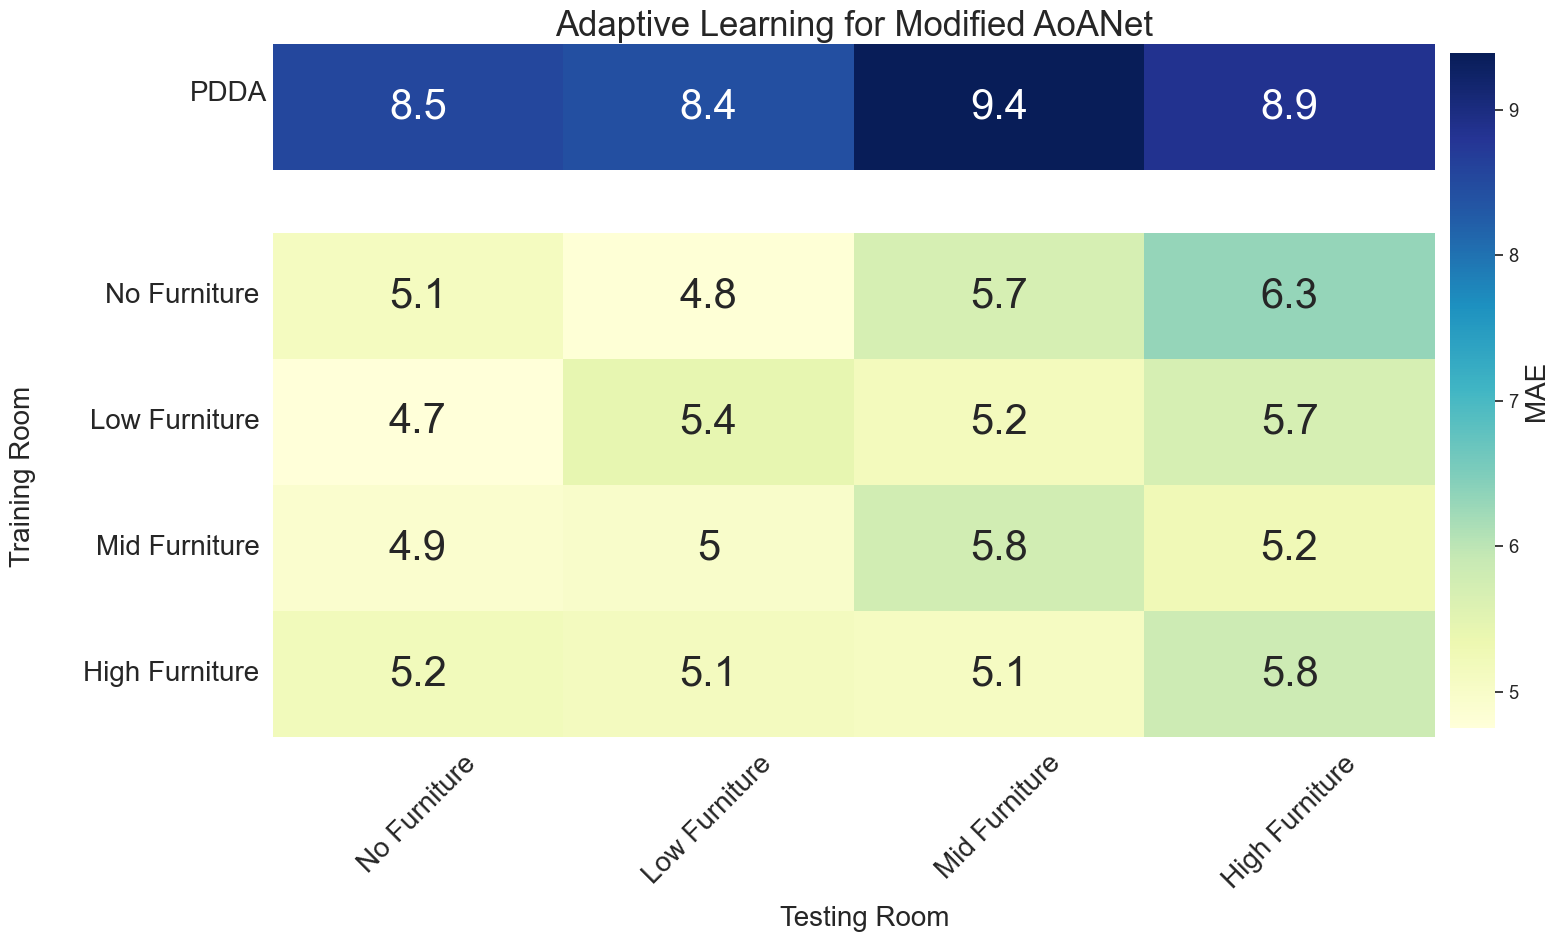

In [191]:

fig, ax = plt.subplots(2,1, sharex=True, figsize=(15,9), gridspec_kw={'height_ratios': [1,4]})
cbar_ax = fig.add_axes([.91, .12, .03, .75])
vmax = np.max(pdda_df)
vmin = np.min(transfer.values)
sns.heatmap(pdda_df['pdda'].values.reshape(4,1).T,annot=True, annot_kws={"size": 30}, cmap="YlGnBu", vmax = vmax, vmin = vmin, cbar_ax = cbar_ax,ax=ax[0], xticklabels=False, yticklabels=False)
sns.heatmap(transfer, annot=True, annot_kws={"size": 30}, cbar=False, vmax = vmax, vmin = vmin, cmap="YlGnBu", cbar_ax = None, ax=ax[1])
ax[0].set_ylabel('PDDA', rotation=0, ha='right', fontsize=20)
sns.set(font_scale=1.2)
fig.text(0.52, -0.1, 'Testing Room', ha='center', fontsize=20)
fig.text(-0.05, 0.4, 'Training Room', va='center', rotation='vertical',fontsize=20)
cbar_ax.set_ylabel('MAE', fontsize=20)

ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0,fontsize=20) 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center', fontsize=20) 
ax[0].set_title('Adaptive Learning for Modified AoANet',fontsize=25)
plt.savefig('figures/Figure5/modified_aoanet',bbox_inches='tight')
plt.savefig('figures/Figure5/modified_aoanet.pdf', bbox_inches='tight')
plt.show()




In [61]:
%history -g -f 'hist.txt'

In [222]:
# no_f.dtypes

In [415]:
no_f = no_f[no_f['anchor'] == 4]
high = high[high['anchor'] == 4]
print(no_f.shape)
print(high.shape)
results, trained_models = transfer_train(no_f, high)
# print(trained_models)
# errors = calculate_mae_errors(results)
# # print(errors)
# mae_error = np.mean(errors['MAE_aoanet'].values) 
# print('mae_error '+str(mae_error))

results = adapt(trained_models, high)

(14682, 39)
(14682, 39)
Epoch : 0
Epoch : 50
Epoch : 0


In [416]:
# results['pdda'][results.iloc[:,0] > 50 ] = 50
# results['pdda'][results.iloc[:,0] < -50 ] = -50
errors = calculate_mae_errors(results)

In [417]:
errors['diff'] = errors.apply(lambda row: row['MAE_pdda'] - row['MAE_aoanet'], axis=1, result_type='expand')

/Users/nikanizharadze/Desktop/AoA/utils.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(-2,15,2)))
/Users/nikanizharadze/Desktop/AoA/utils.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(range(0,8)))


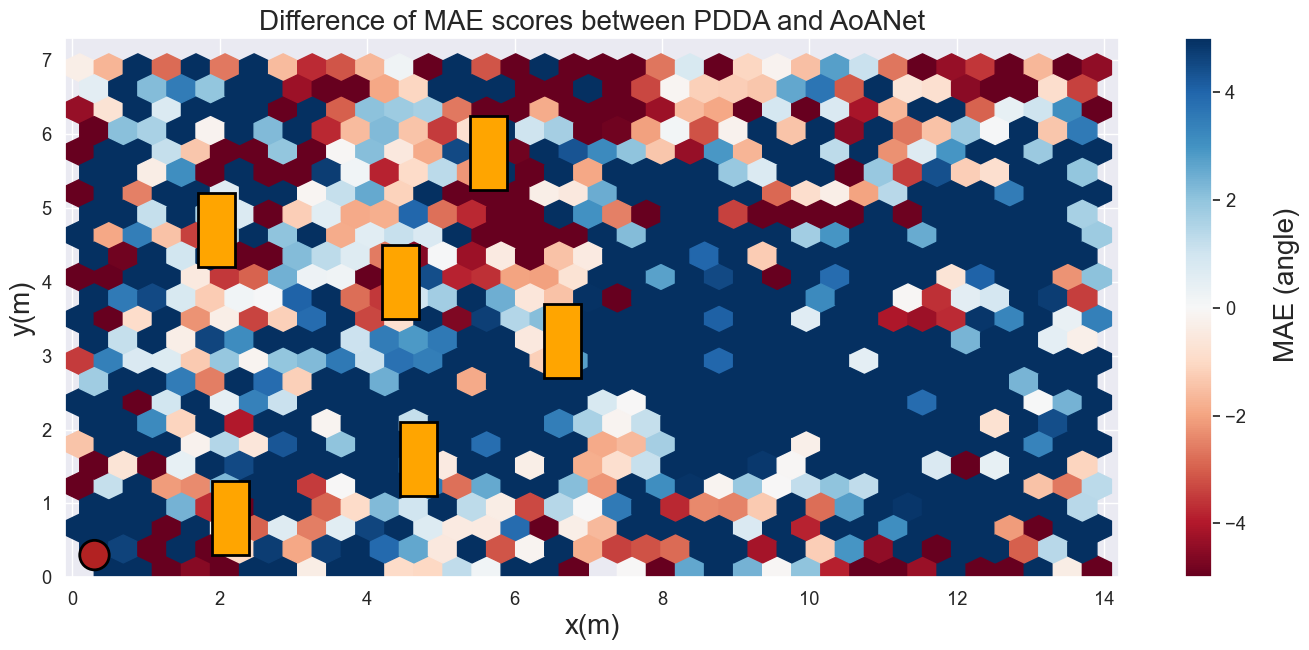

In [418]:
spatial_plot(errors['diff'], errors['x_loc'], errors['y_loc'], 'figures/Figure5/poitwise_adaptive/diff_pdda_aoanet1', 'Difference of MAE scores between PDDA and AoANet', testing_room='testbench_01_furniture_high_concrete', cmap='RdBu', anchors=[4],vmin=-5, vmax=5)


In [422]:
errors.head()

,MAE_pdda,MAE_aoanet,x_loc,y_loc,diff
0,225.000000,45.391281,44.1,43.3,179.608719
0,62.100000,49.271103,44.1,43.5,12.828897
0,62.799998,32.234867,44.1,43.7,30.565131
0,77.200002,5.393616,44.1,43.9,71.806386
0,32.200000,10.723442,44.1,44.1,21.476558


In [440]:
neg = errors['diff'] < -5
pos = errors['diff'] > 10

In [441]:
neg.value_counts()

False    1964
True      383
Name: diff, dtype: int64

In [439]:
pos.value_counts()

False    1748
True      599
Name: diff, dtype: int64

In [285]:
627

627

In [426]:
errors.shape

(2347, 5)